In [5]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def get_results_dir(model_name, dataset_name, model_type, fault_type):
    d = {
        'vgg16': {
            'cifar10': {
                'full': {

                    'faults_layer': './logs/vgg16/cifar10/faults_layer',
                },
               
            }
        },
         'resnet56': {
            'cifar10': {
                'full': {
                    'faults_layer': './logs/resnet56/cifar10/faults_layer',

                },
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(model_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, model_type):
    d = {'vgg16': {
        'cifar10': {
            'full': 0.9388, },
        'resnet56': {
            'cifar10':{
                'full': 0.9269, }
        }}
        }
    return d[model_name][dataset_name][model_type]

model_name = 'vgg16'
# model_name = 'resnet56'
dataset_name = 'cifar10'

model_types = ['full']
fault_types = ['faults_layer']


In [7]:
def parse_log(log_path):
    # trial: 9, bit_position: 0, n_faults: 1, total_params: 1728, 
    # flipped_bits: 1 (1.808449e-05), changed_params: 1 (5.787037e-04), test_time: 2, test_accuracy: 0.938800
    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = float(item.split()[1])
                    if 'trial' in item:
                        trial = int(item.split()[1])
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    return result 

def load_results(model_type, fault_type):
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, model_type, fault_type)
    if not results_dir:
        return None 
    
    # ./cifar/l1-norm-pruning/logs/vgg16/cifar10/faults_layer/param-0/bit-0/nbits-1
    param_id_folders = os.listdir(results_dir)
    for param_id_folder in param_id_folders:
        param_id = int(param_id_folder.split('-')[-1])
        param_id_path = os.path.join(results_dir, param_id_folder)
        if param_id not in results:
            results[param_id] = {} 
        # get the bit folder 
        for bit_position_folder in os.listdir(param_id_path):
            bit_position = int(bit_position_folder.split('-')[-1])
            bit_position_path = os.path.join(param_id_path, bit_position_folder)
            if bit_position not in results[param_id]:
                results[param_id][bit_position] = {} 
            # get number of bits folder
            for nbits_folder in os.listdir(bit_position_path):
                nbits = int(nbits_folder.split('-')[-1])
                log_path = os.path.join(bit_position_path, nbits_folder, 'logs.txt')
                if os.path.isfile(log_path):
                    results[param_id][bit_position][nbits] = parse_log(log_path)
    return results 
        
data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for model_type in model_types:
    data[model_type] = {} 
    for fault_type in fault_types:
        results = load_results(model_type, fault_type)
        if results:
            data[model_type][fault_type] = results 

# print(data)


prec1: 0.9388


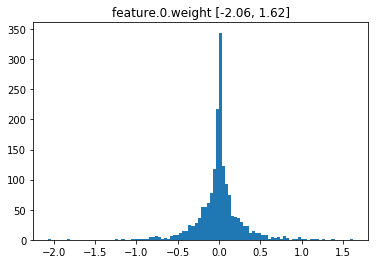

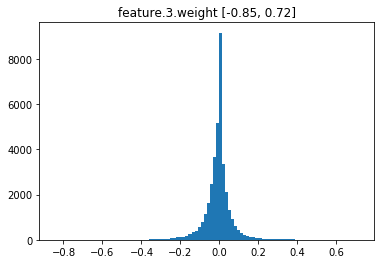

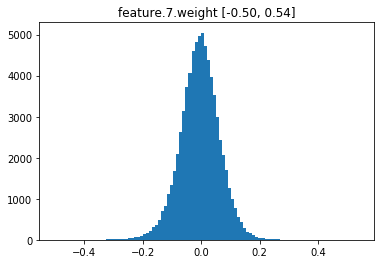

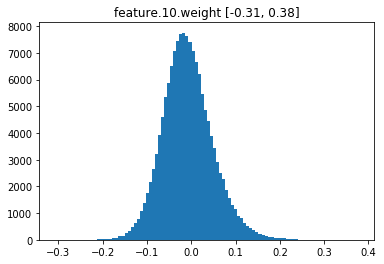

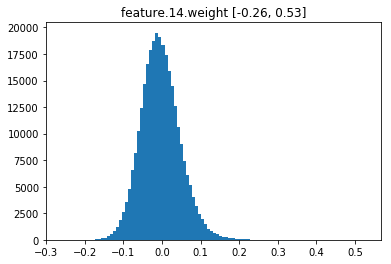

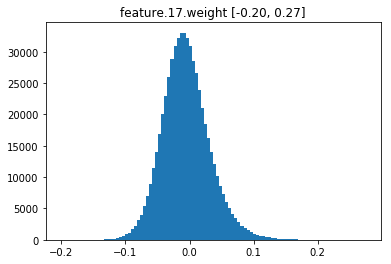

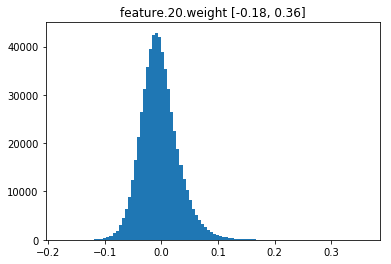

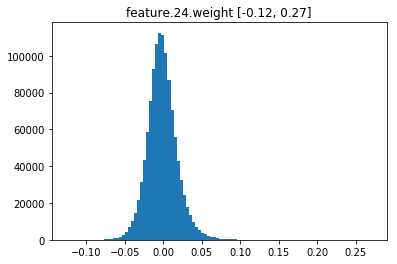

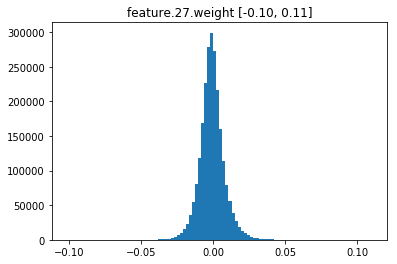

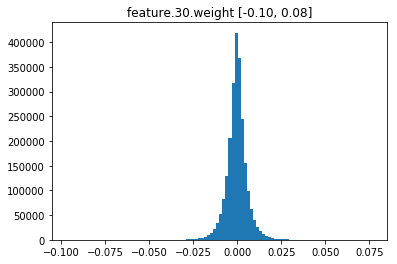

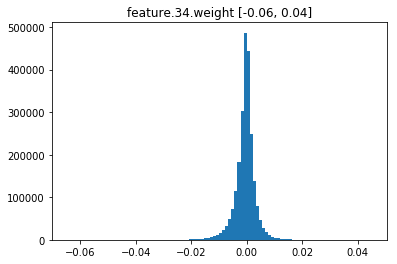

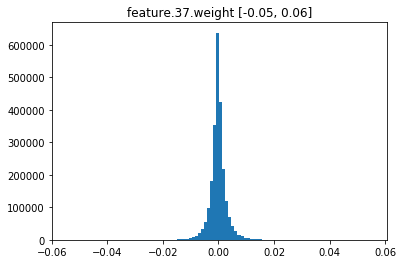

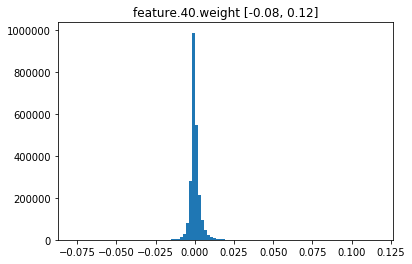

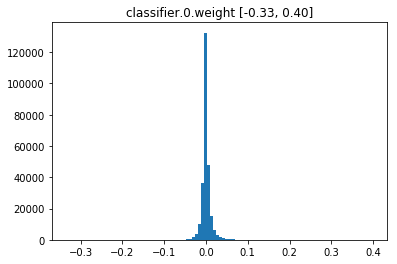

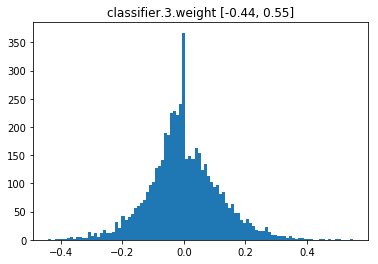

In [68]:
import torch 

model_path = './logs/'+ model_name +'/' + dataset_name +'/model_best.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['best_prec1']
print('prec1:', prec1)
state_dict = checkpoint['state_dict']
param_id_to_name = {}
param_id_to_shape = {} 
param_id = 0 
weights_id = []

for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) >= 2:
        weights_id.append(param_id)
        param_id_to_shape[param_id] = tuple(tensor.size())
        
    if 'weight' in key or 'bias' in key:
        param_id_to_name[param_id] = key
        param_id += 1
    if len(tensor.size()) < 2:
        continue
    minv, maxv = tensor.min().item(), tensor.max().item() 
    plt.hist(tensor.cpu().numpy().ravel(), bins=100)
    plt.title(key+' [%.2f, %.2f]' %(minv, maxv))
    plt.show()


In [56]:
# print(len(param_id_to_name), param_id_to_name)
print(weights_id)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]


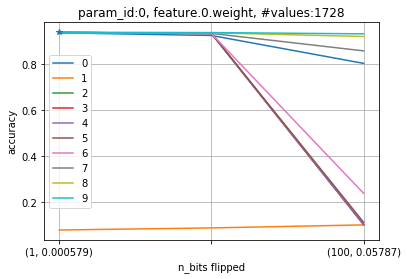

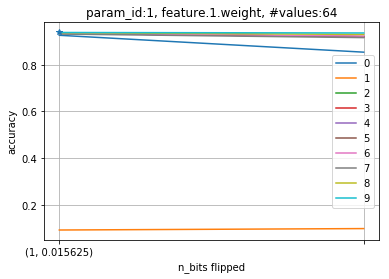

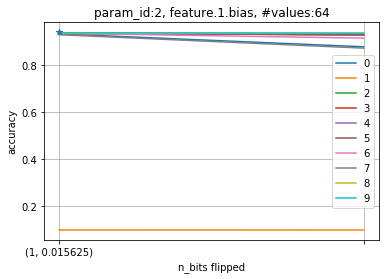

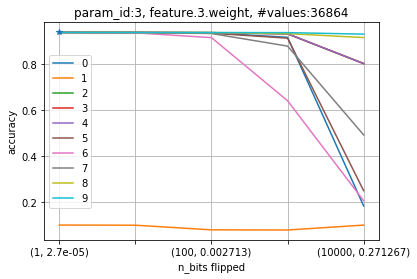

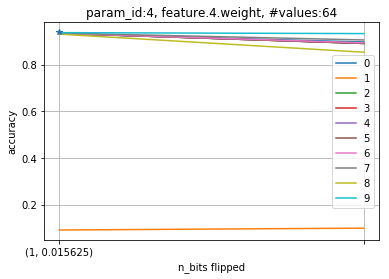

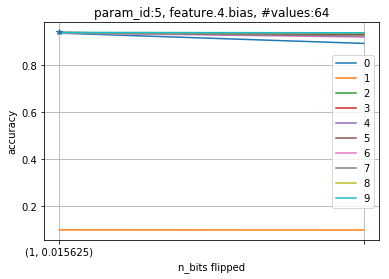

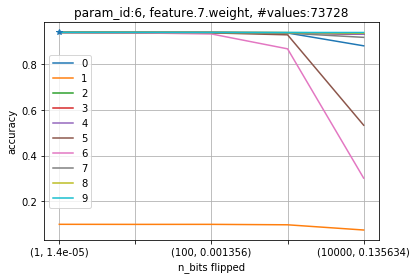

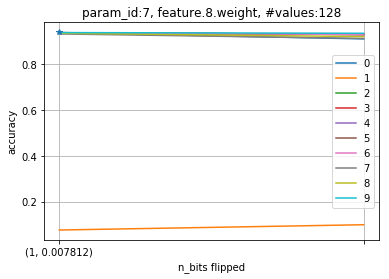

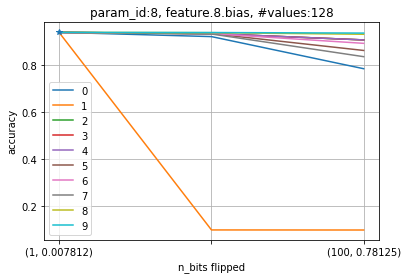

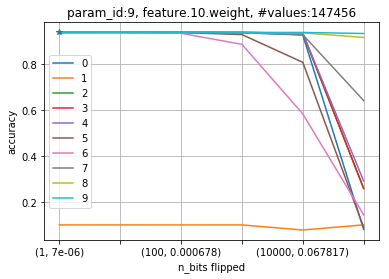

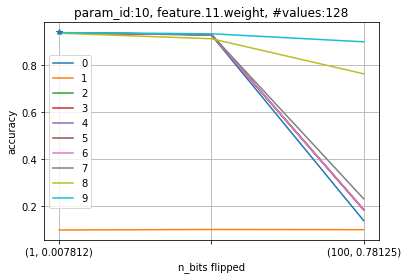

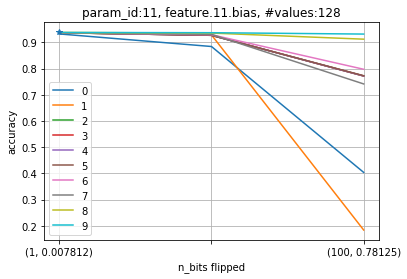

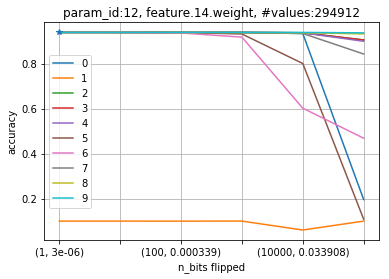

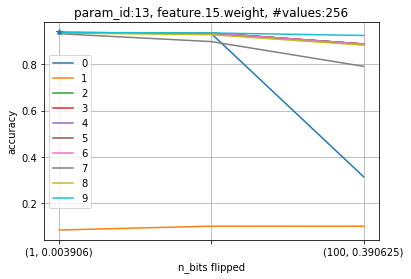

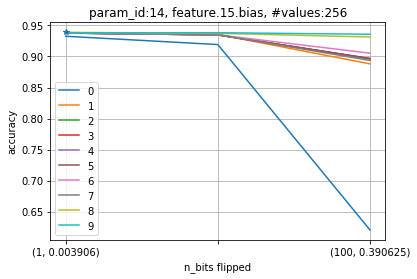

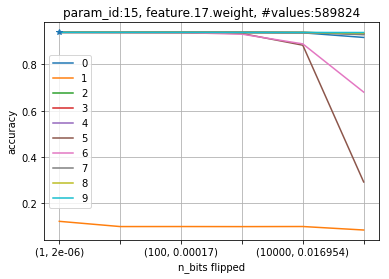

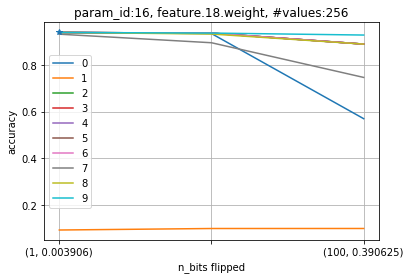

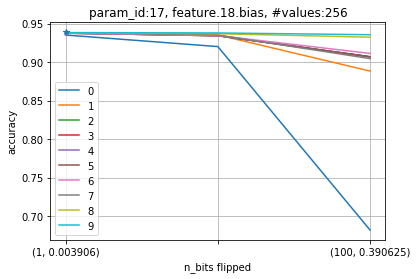

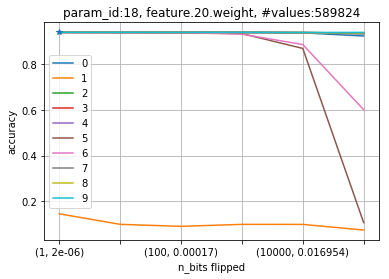

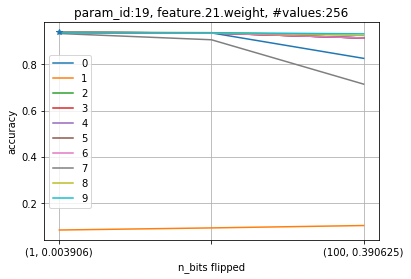

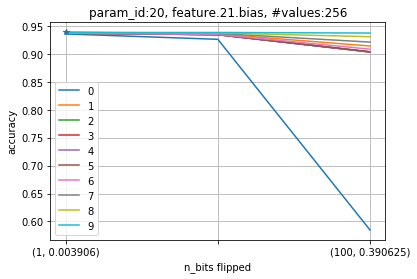

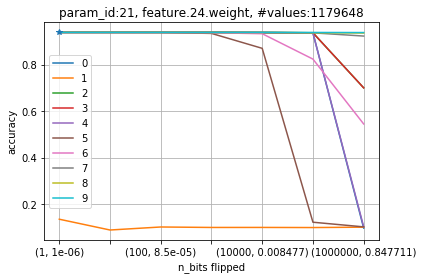

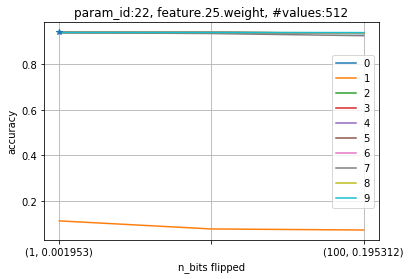

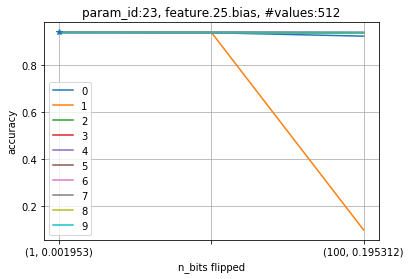

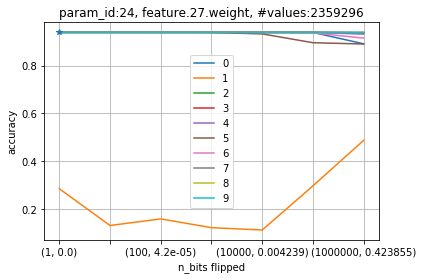

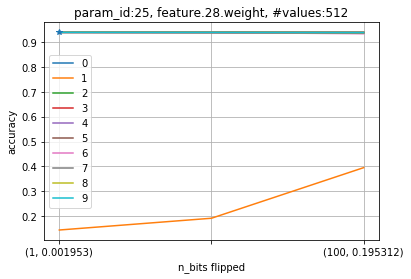

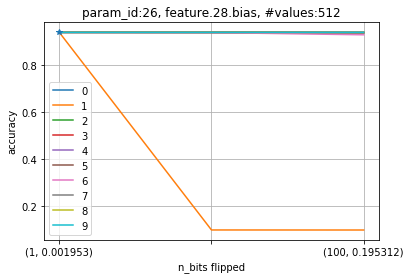

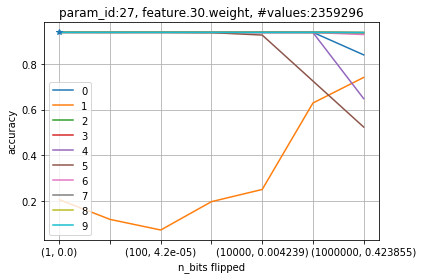

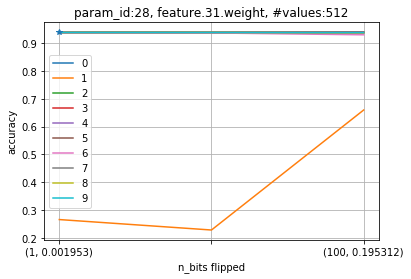

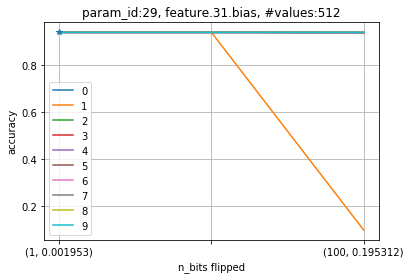

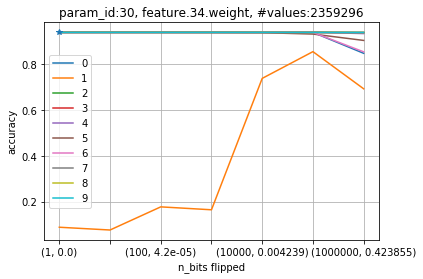

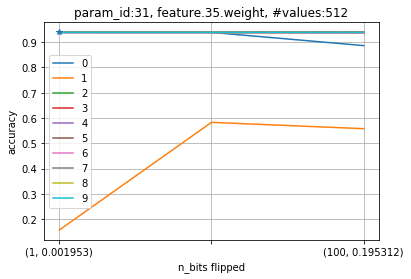

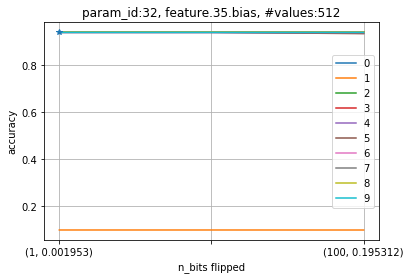

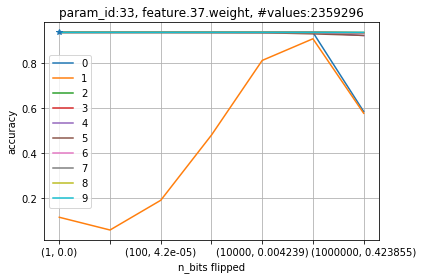

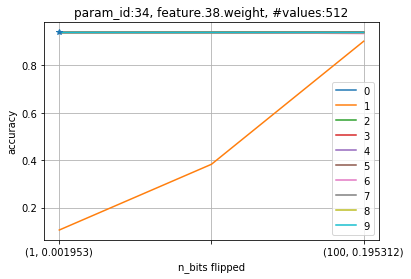

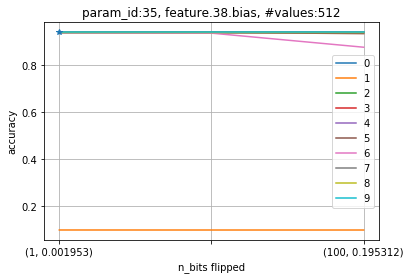

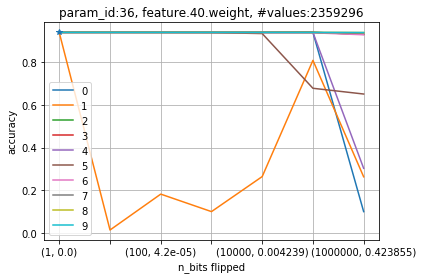

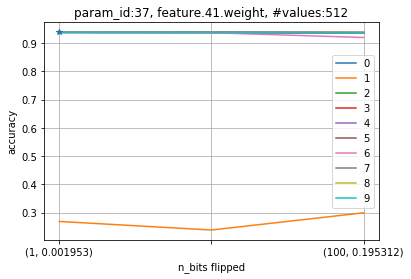

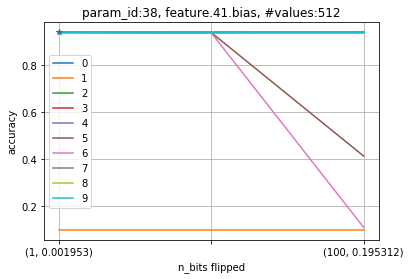

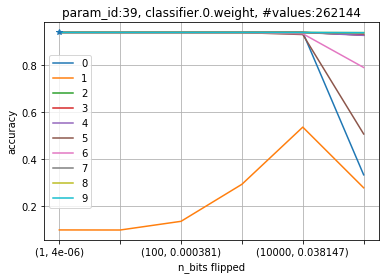

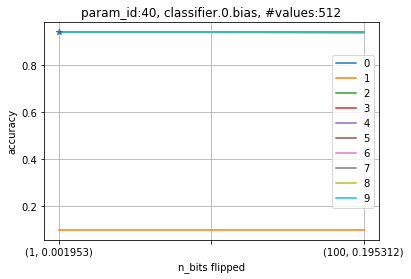

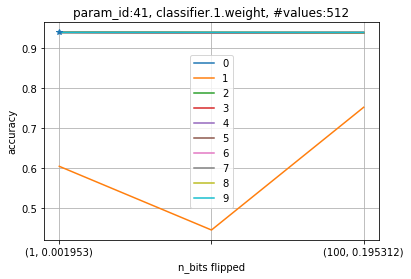

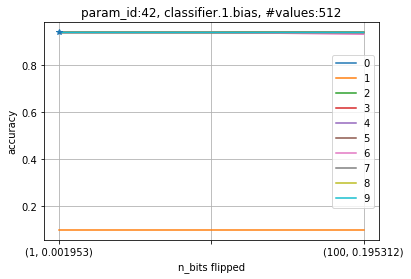

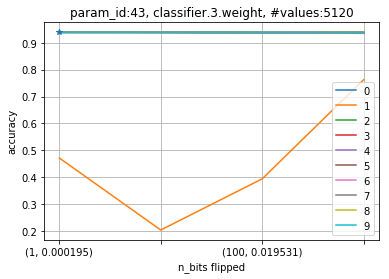

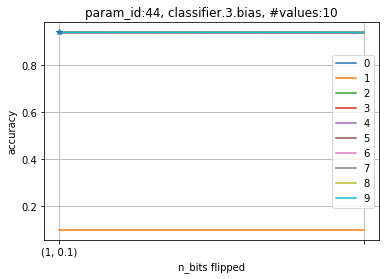

In [28]:
# compare same param_id, same bit_position, x: n_bits, y: accuracy 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for param_id in sorted(data[model_type][fault_type].keys()):
            bit_positions = sorted(data[model_type][fault_type][param_id].keys())[:10]
            
            for bit_position in bit_positions:
                res = data[model_type][fault_type][param_id][bit_position]
                n_bits_list = sorted(res.keys())
                num_values = res[n_bits_list[0]][0, 0]
                
                fault_rates = [round(n_bits*1.0/num_values, 6) for n_bits in n_bits_list]
                accuracies = [np.min(res[n_bits], axis=0)[2] for n_bits in n_bits_list]
                x = range(len(n_bits_list))
                plt.plot(x, accuracies, label=str(bit_position))
            plt.legend()    
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
            plt.grid()
            plt.ylabel('accuracy')
            plt.xlabel('n_bits flipped')
            plt.title('param_id:%d, %s, #values:%d' %(param_id, param_id_to_name[param_id], res[n_bits_list[0]][0, 0]))
            plt.xticks(x, [s if not i%2 else '' for i, s in enumerate(map(str, zip(n_bits_list, fault_rates)))])
            plt.plot(fault_free_accuracy, marker='*')
            plt.show()
                

1 [(9, 0.9386), (10, 0.9386), (11, 0.9386), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9378), (10, 0.9384), (11, 0.9384), (12, 0.9386), (13, 0.9387), (14, 0.9388), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9322), (10, 0.9373), (11, 0.9382), (12, 0.9383), (13, 0.9385), (14, 0.9387), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


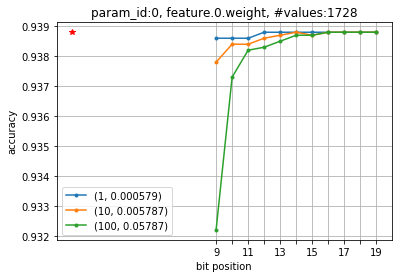

1 [(9, 0.9382), (10, 0.9384), (11, 0.9386), (12, 0.9385), (13, 0.9388), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9361), (10, 0.9377), (11, 0.9384), (12, 0.9383), (13, 0.9387), (14, 0.9387), (15, 0.9388), (16, 0.9387), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


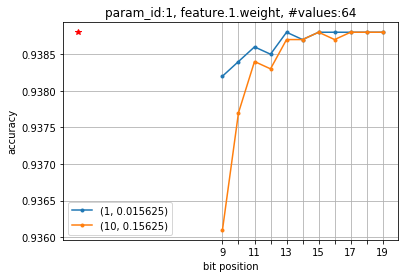

1 [(9, 0.9373), (10, 0.9377), (11, 0.9382), (12, 0.9386), (13, 0.9384), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9357), (10, 0.937), (11, 0.938), (12, 0.9387), (13, 0.9384), (14, 0.9386), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


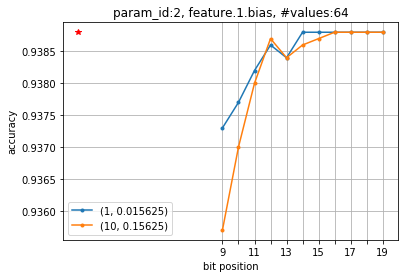

1 [(9, 0.9386), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9382), (10, 0.9385), (11, 0.9387), (12, 0.9388), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9379), (10, 0.9384), (11, 0.9385), (12, 0.9388), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9376), (10, 0.938), (11, 0.9385), (12, 0.9385), (13, 0.9386), (14, 0.9386), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9309), (10, 0.936), (11, 0.9374), (12, 0.9379), (13, 0.9381), (14, 0.9384), (15, 0.9385), (16, 0.9387), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


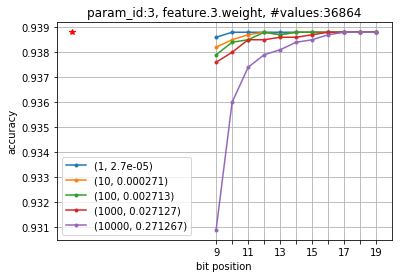

1 [(9, 0.9375), (10, 0.9384), (11, 0.9385), (12, 0.9385), (13, 0.9387), (14, 0.9386), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9334), (10, 0.9358), (11, 0.9377), (12, 0.9384), (13, 0.9383), (14, 0.9387), (15, 0.9385), (16, 0.9387), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


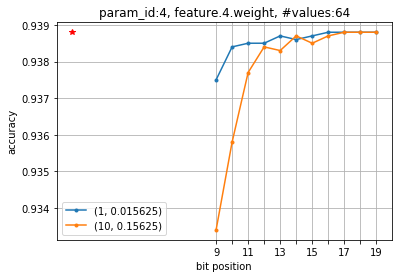

1 [(9, 0.9383), (10, 0.9383), (11, 0.9386), (12, 0.9387), (13, 0.9386), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.937), (10, 0.9378), (11, 0.9381), (12, 0.9386), (13, 0.9387), (14, 0.9388), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


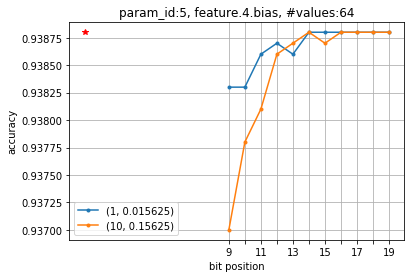

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9385), (10, 0.9386), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9383), (10, 0.9385), (11, 0.9385), (12, 0.9386), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9381), (10, 0.9378), (11, 0.9383), (12, 0.9384), (13, 0.9386), (14, 0.9387), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


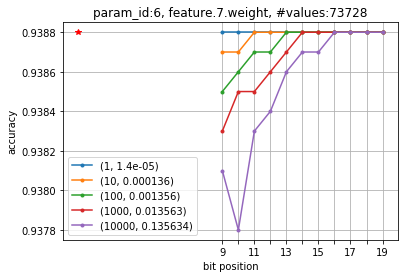

1 [(9, 0.9378), (10, 0.9384), (11, 0.9384), (12, 0.9387), (13, 0.9386), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9347), (10, 0.937), (11, 0.9385), (12, 0.9383), (13, 0.9386), (14, 0.9385), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


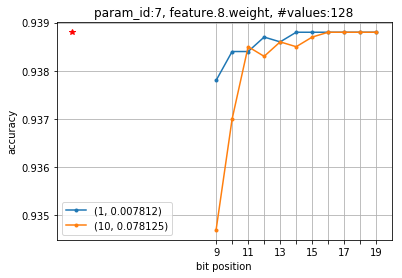

1 [(9, 0.9386), (10, 0.9388), (11, 0.9386), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.938), (10, 0.9384), (11, 0.9386), (12, 0.9386), (13, 0.9387), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9356), (10, 0.9381), (11, 0.9384), (12, 0.9382), (13, 0.9386), (14, 0.9389), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


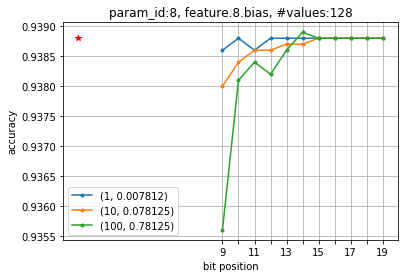

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9386), (10, 0.9386), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9381), (10, 0.9388), (11, 0.9388), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9384), (10, 0.9381), (11, 0.939), (12, 0.9386), (13, 0.9389), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9337), (10, 0.9368), (11, 0.9388), (12, 0.9382), (13, 0.9385), (14, 0.9388), (15, 0.9388), (16, 0.9386), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


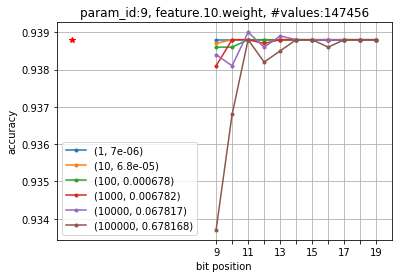

1 [(9, 0.9377), (10, 0.9382), (11, 0.9384), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9328), (10, 0.9366), (11, 0.938), (12, 0.9384), (13, 0.9385), (14, 0.9386), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.8985), (10, 0.928), (11, 0.9354), (12, 0.9377), (13, 0.9379), (14, 0.9388), (15, 0.9386), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


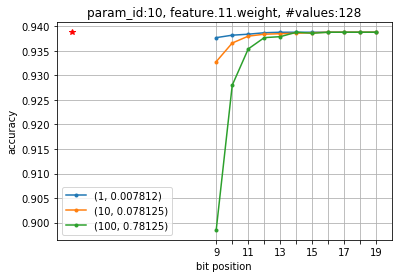

1 [(9, 0.9384), (10, 0.9387), (11, 0.9386), (12, 0.9389), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9374), (10, 0.9383), (11, 0.9384), (12, 0.9385), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9322), (10, 0.9371), (11, 0.9381), (12, 0.9388), (13, 0.9386), (14, 0.9388), (15, 0.9386), (16, 0.9387), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


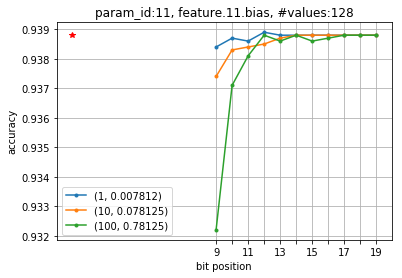

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.939), (10, 0.9388), (11, 0.9385), (12, 0.9386), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9387), (10, 0.9382), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9367), (10, 0.9379), (11, 0.9385), (12, 0.9382), (13, 0.9386), (14, 0.9386), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


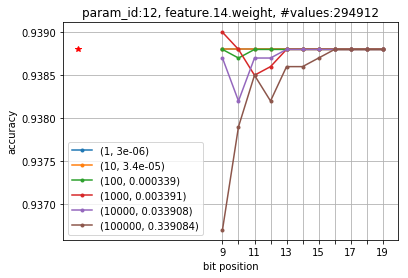

1 [(9, 0.9384), (10, 0.9384), (11, 0.9387), (12, 0.9386), (13, 0.9388), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9361), (10, 0.9377), (11, 0.9385), (12, 0.9389), (13, 0.9387), (14, 0.9389), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9253), (10, 0.9353), (11, 0.9376), (12, 0.9383), (13, 0.9383), (14, 0.9387), (15, 0.9385), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


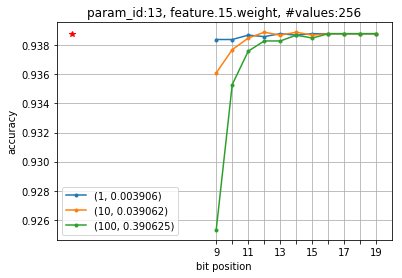

1 [(9, 0.9382), (10, 0.9384), (11, 0.9388), (12, 0.9385), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9383), (10, 0.9385), (11, 0.9385), (12, 0.9385), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9358), (10, 0.9379), (11, 0.9379), (12, 0.9382), (13, 0.9384), (14, 0.9388), (15, 0.9389), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


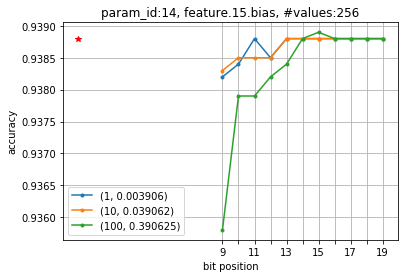

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9384), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9383), (10, 0.9384), (11, 0.9387), (12, 0.9387), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9381), (10, 0.9381), (11, 0.9387), (12, 0.9387), (13, 0.9387), (14, 0.9389), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


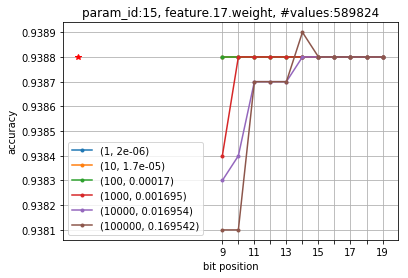

1 [(9, 0.9382), (10, 0.9384), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9357), (10, 0.9381), (11, 0.938), (12, 0.9385), (13, 0.9385), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9272), (10, 0.9351), (11, 0.9374), (12, 0.9377), (13, 0.9384), (14, 0.9382), (15, 0.9389), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


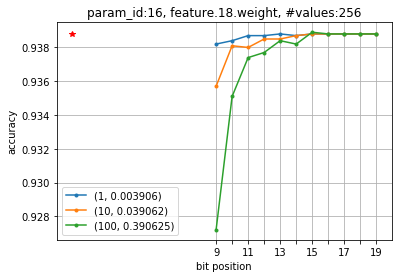

1 [(9, 0.9385), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.938), (10, 0.938), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9357), (10, 0.937), (11, 0.9387), (12, 0.9381), (13, 0.9385), (14, 0.9387), (15, 0.9387), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


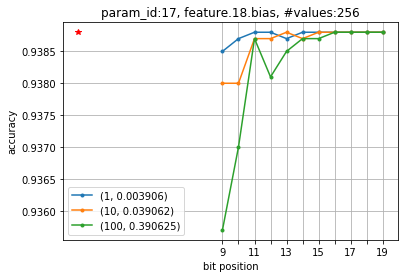

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9387), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9389), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9383), (10, 0.9387), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9387), (10, 0.9382), (11, 0.9386), (12, 0.9387), (13, 0.9389), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


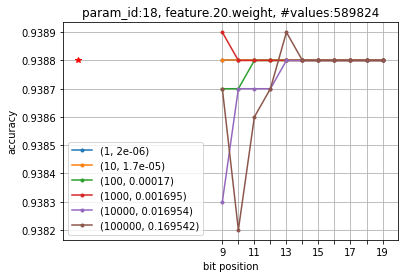

1 [(9, 0.9384), (10, 0.9386), (11, 0.9388), (12, 0.9387), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9372), (10, 0.9382), (11, 0.9381), (12, 0.9386), (13, 0.9387), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9323), (10, 0.9375), (11, 0.9384), (12, 0.9385), (13, 0.9383), (14, 0.9388), (15, 0.9387), (16, 0.9386), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


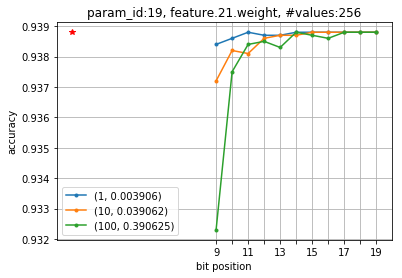

1 [(9, 0.9386), (10, 0.9387), (11, 0.9387), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9386), (10, 0.9385), (11, 0.9385), (12, 0.9389), (13, 0.9388), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9375), (10, 0.9385), (11, 0.9382), (12, 0.9385), (13, 0.9383), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


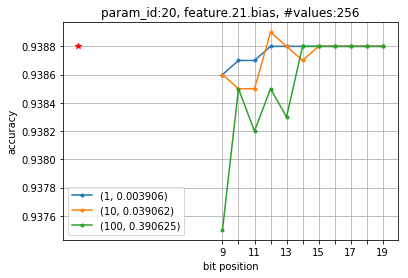

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.939), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9385), (10, 0.9388), (11, 0.9387), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000000 [(9, 0.9381), (10, 0.9391), (11, 0.9386), 

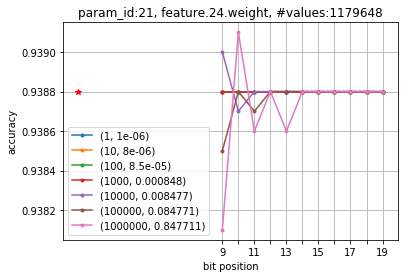

1 [(9, 0.9384), (10, 0.9387), (11, 0.9388), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9383), (10, 0.9384), (11, 0.9386), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9377), (10, 0.9385), (11, 0.9387), (12, 0.9384), (13, 0.9387), (14, 0.9387), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


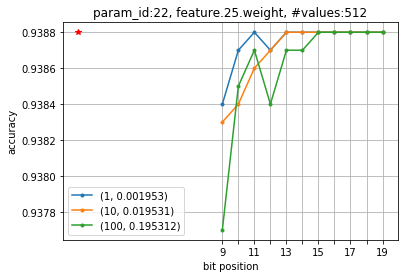

1 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9387), (11, 0.9386), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9384), (10, 0.9387), (11, 0.9386), (12, 0.9388), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


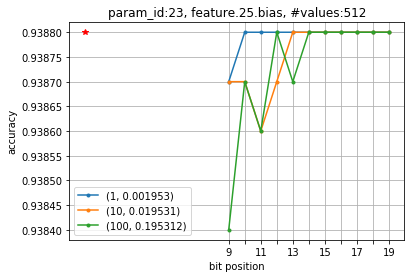

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000000 [(9, 0.9386), (10, 0.9388), (11, 0.9388),

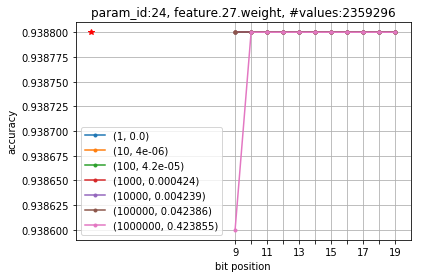

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9386), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9381), (10, 0.9386), (11, 0.9385), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


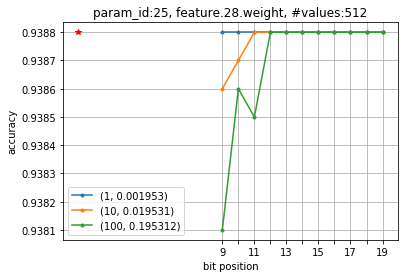

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9389), (10, 0.9387), (11, 0.9388), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


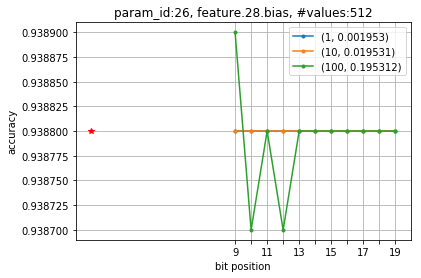

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000000 [(9, 0.9382), (10, 0.9387), (11, 0.9388),

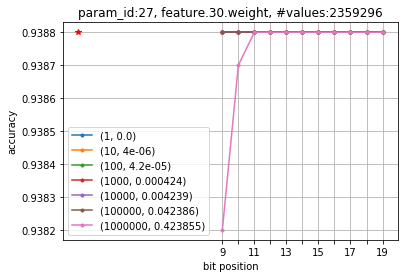

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9386), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9385), (10, 0.9387), (11, 0.9386), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


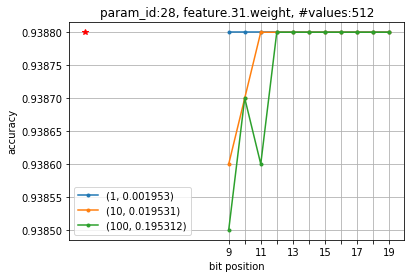

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9389), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


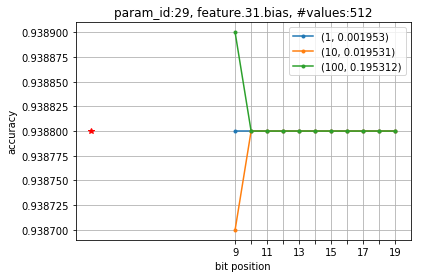

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000000 [(9, 0.9386), (10, 0.9387), (11, 0.9388),

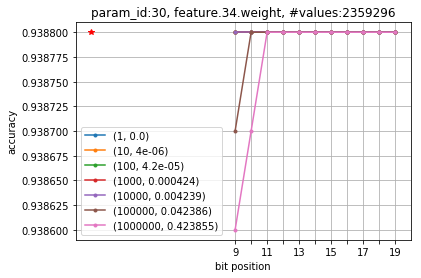

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9386), (10, 0.9386), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


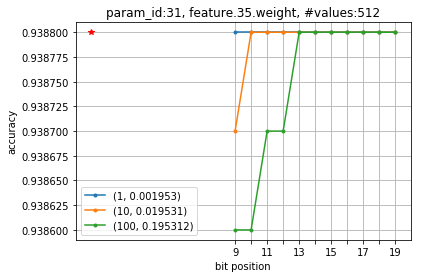

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


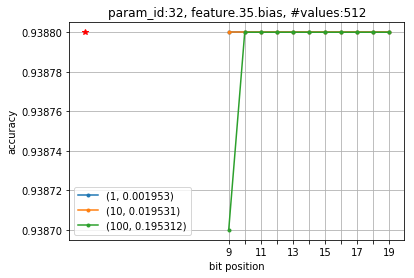

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000000 [(9, 0.9386), (10, 0.9389), (11, 0.9388),

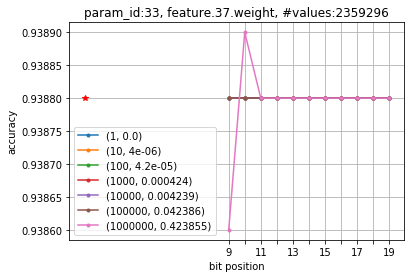

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9387), (10, 0.9386), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


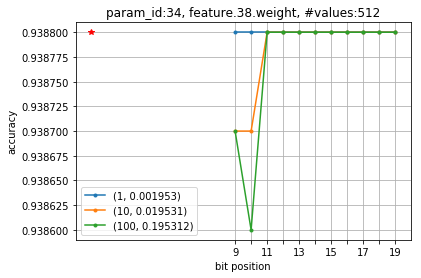

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


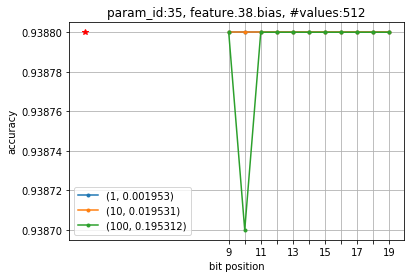

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9386), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000000 [(9, 0.9381), (10, 0.9386), (11, 0.9389),

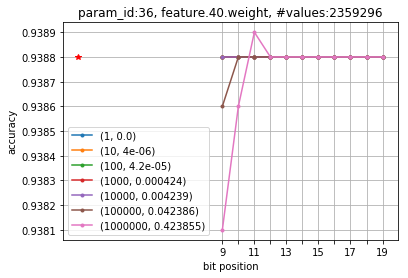

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9387), (11, 0.9389), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9379), (10, 0.9384), (11, 0.9389), (12, 0.9386), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


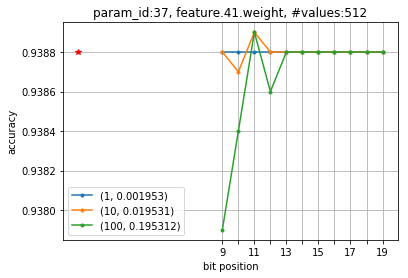

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9387), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9387), (10, 0.9385), (11, 0.9388), (12, 0.9387), (13, 0.9387), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


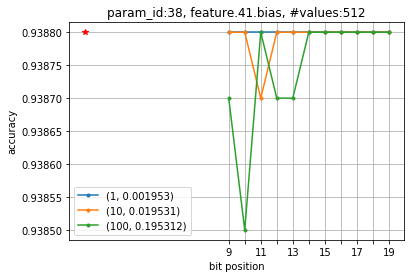

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10000 [(9, 0.9387), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100000 [(9, 0.9378), (10, 0.9384), (11, 0.9387), (12, 0.9387), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


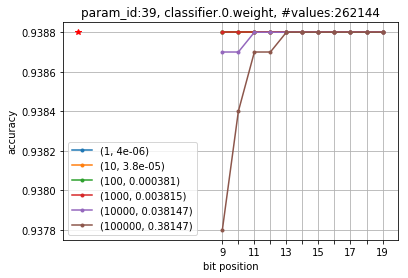

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


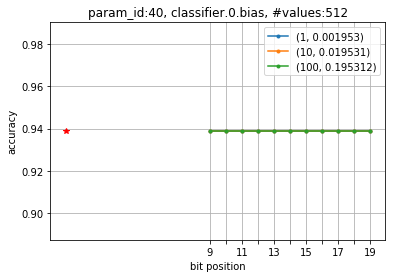

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9386), (10, 0.9388), (11, 0.9387), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


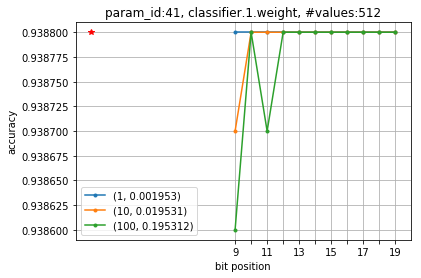

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9387), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


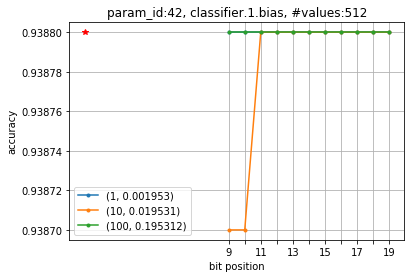

1 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
100 [(9, 0.9387), (10, 0.9387), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
1000 [(9, 0.9384), (10, 0.9385), (11, 0.9387), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


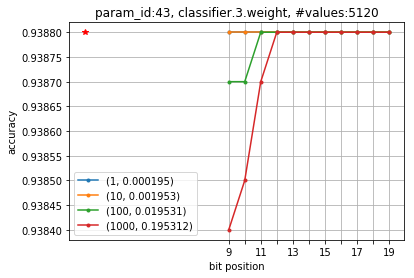

1 [(9, 0.9387), (10, 0.9388), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]
10 [(9, 0.9388), (10, 0.9389), (11, 0.9388), (12, 0.9388), (13, 0.9388), (14, 0.9388), (15, 0.9388), (16, 0.9388), (17, 0.9388), (18, 0.9388), (19, 0.9388)]


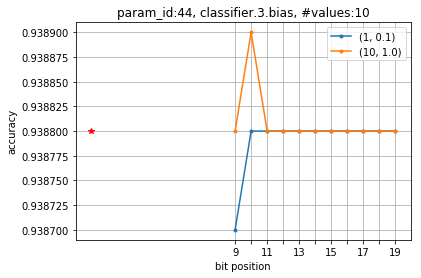

In [108]:
# compare same param_id, same n_bits, x: bit_position, y: accuracy 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        for param_id in sorted(data[model_type][fault_type].keys()):
            bit_positions = sorted(data[model_type][fault_type][param_id].keys())[9:20]
            n_bits_list = sorted(data[model_type][fault_type][param_id][0].keys())
            
            for n_bits in n_bits_list:   
                res = data[model_type][fault_type][param_id]
                num_values = res[bit_positions[0]][n_bits][0, 0]
                accuracies = [np.min(res[bit_position][n_bits], axis=0)[2] for bit_position in bit_positions]
                print(n_bits, list(zip(bit_positions, accuracies)))
                plt.plot(bit_positions, accuracies, marker='.', 
                         label=str((n_bits, round(n_bits*1.0/num_values, 6))))
                
            plt.legend()    
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
            plt.grid()
            plt.ylabel('accuracy')
            plt.xlabel('bit position')
            plt.title('param_id:%d, %s, #values:%d' %(param_id, param_id_to_name[param_id], res[0][1][0, 0])) # 0: bit position; 1: n_bits 
            plt.xticks(bit_positions, map(str, [x if x%2 else '' for x in bit_positions ]))
            plt.plot(fault_free_accuracy, marker='*', color='r')
            plt.show()
                

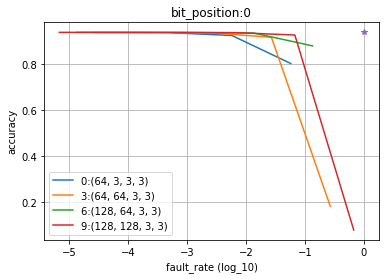

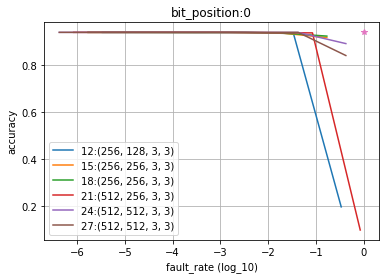

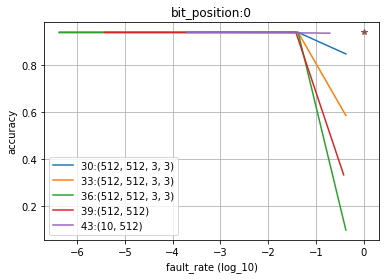

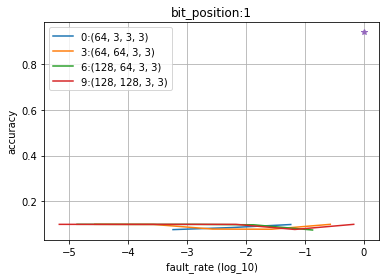

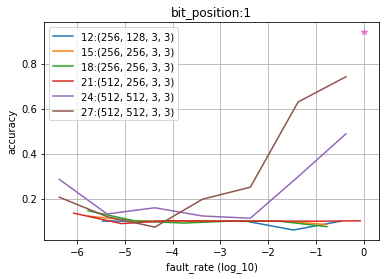

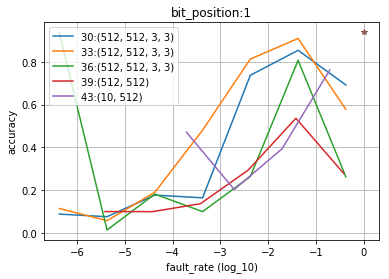

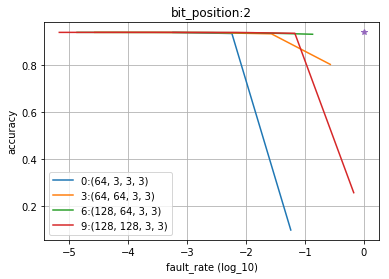

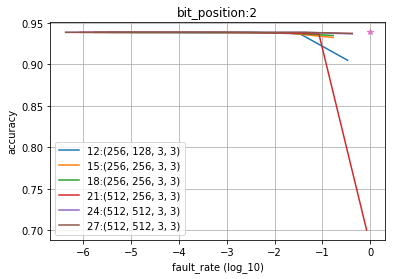

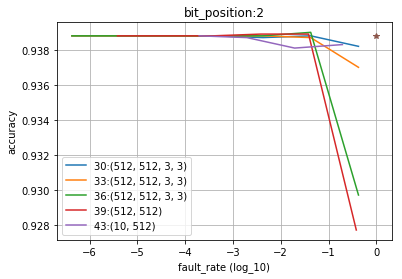

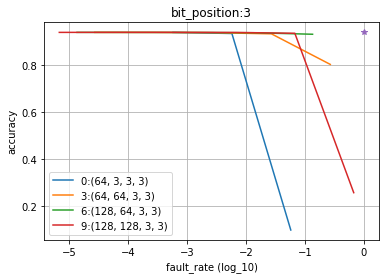

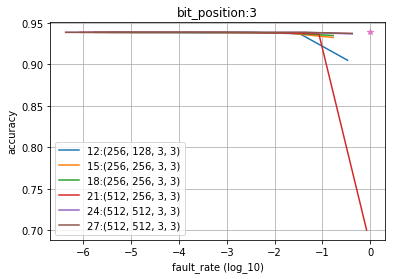

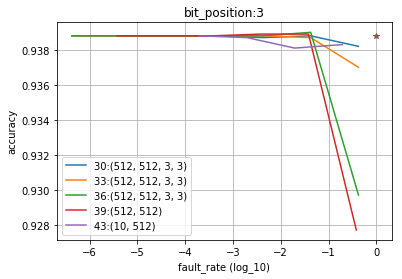

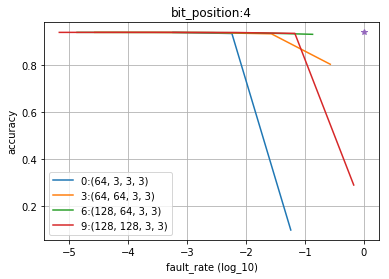

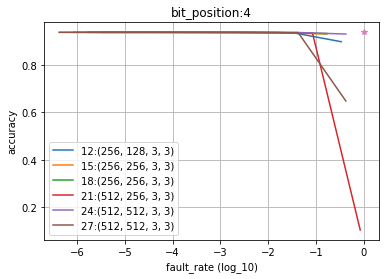

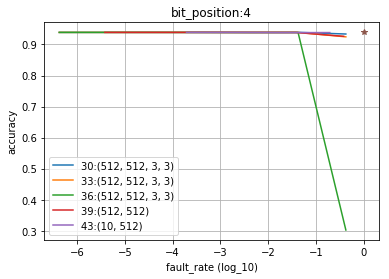

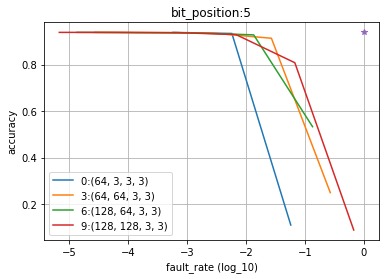

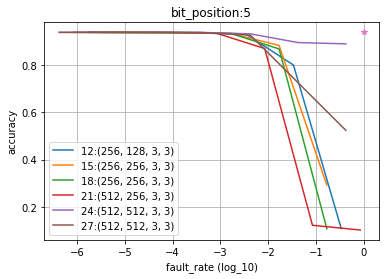

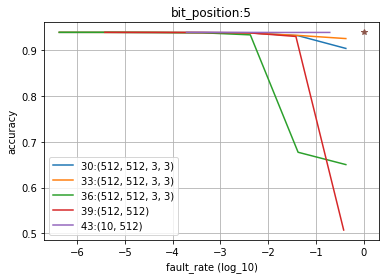

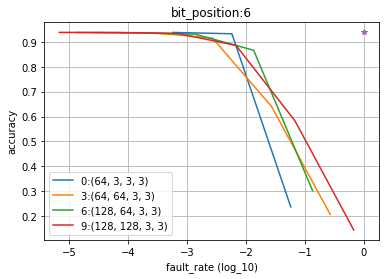

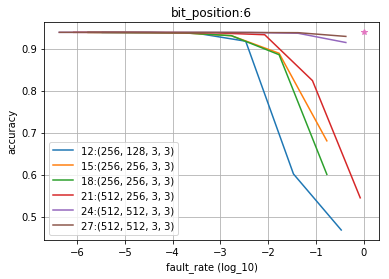

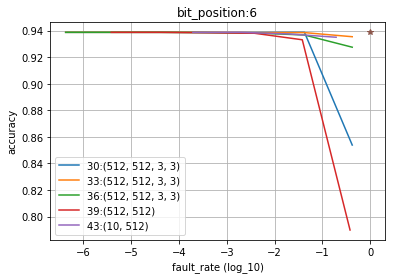

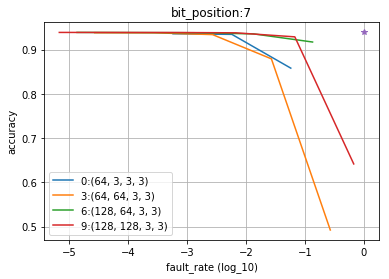

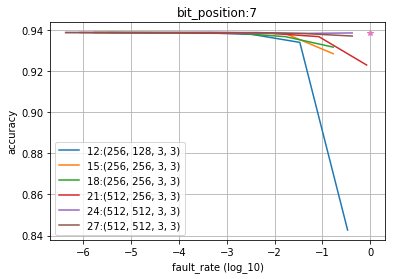

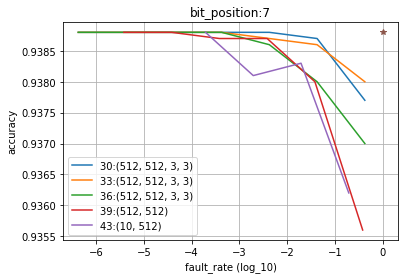

In [73]:
# x: fault_rate, y:accuracy; lengends: param_id 
import math 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for bit_position in range(0, 8):
            
            for param_id in sorted(data[model_type][fault_type].keys()):
                if param_id not in weights_id:
                    continue 
                res = data[model_type][fault_type][param_id][bit_position]
                n_bits_list = sorted(res.keys())
                num_values = res[n_bits_list[0]][0, 0]

                fault_rates = [n_bits*1.0/num_values for n_bits in n_bits_list]
#                 print(fault_rates)
                accuracies = [np.min(res[n_bits], axis=0)[2] for n_bits in n_bits_list]
                plt.plot([math.log10(x) for x in fault_rates], accuracies, 
                         label='%d:%s' %(param_id, param_id_to_shape[param_id]))
                
                if param_id in [9, 27, 43]:
                    plt.legend()    
        #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
                    plt.grid()
                    plt.ylabel('accuracy')
                    plt.xlabel('fault_rate (log_10)')
                    plt.title('bit_position:%d' %(bit_position))
                    plt.plot(fault_free_accuracy, marker='*')
                    plt.show()
                
                


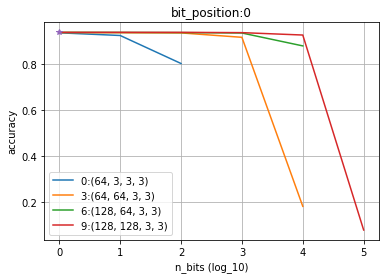

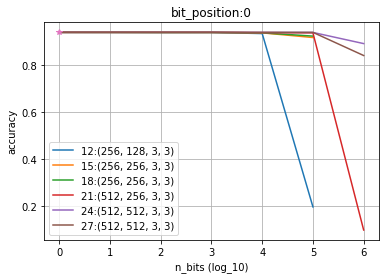

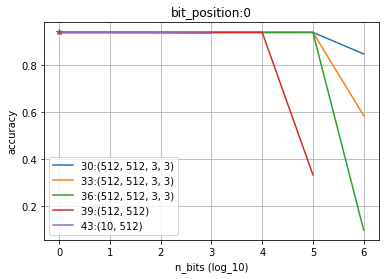

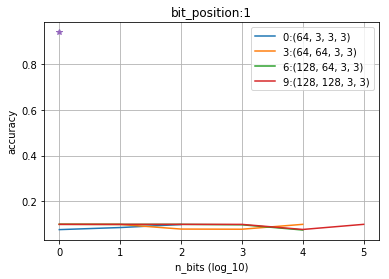

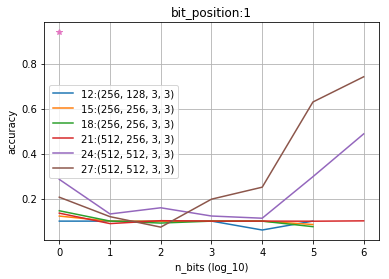

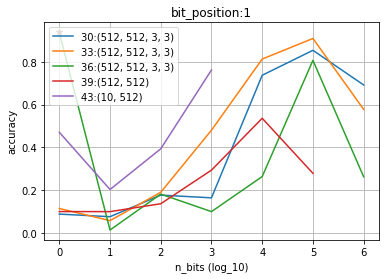

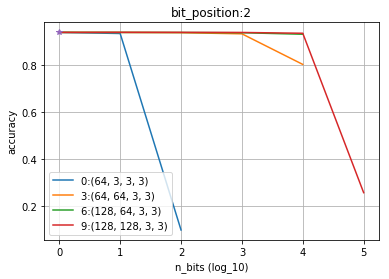

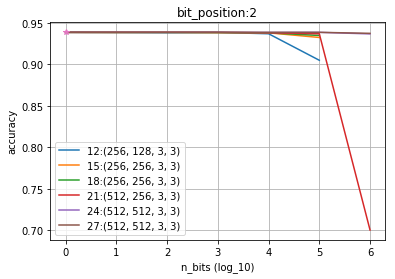

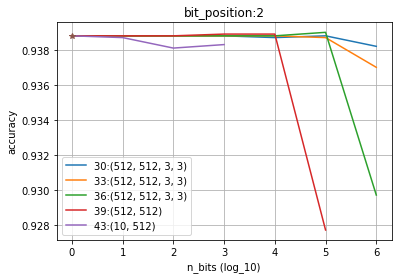

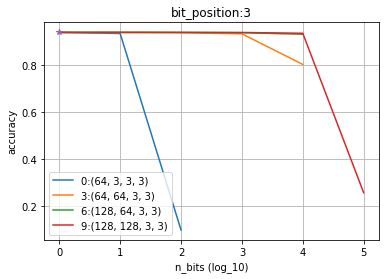

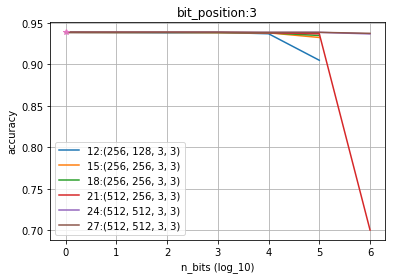

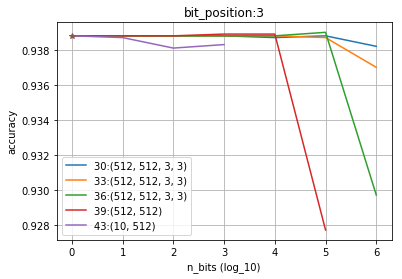

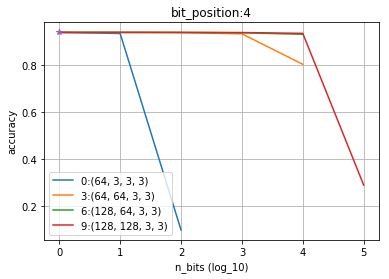

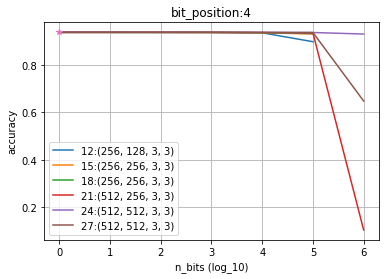

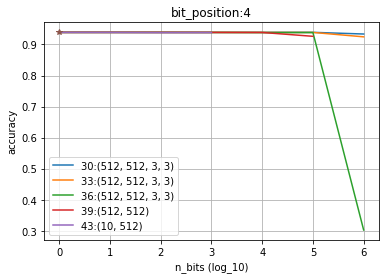

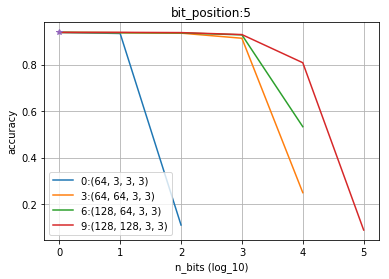

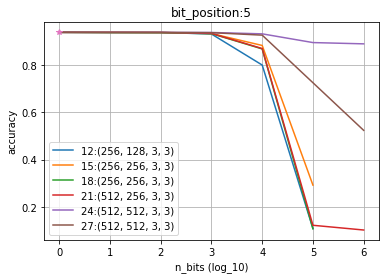

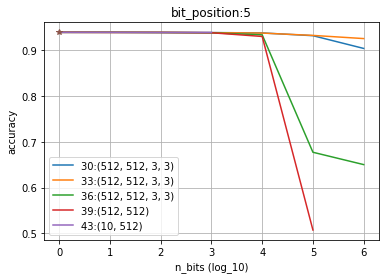

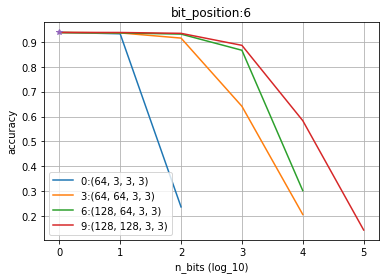

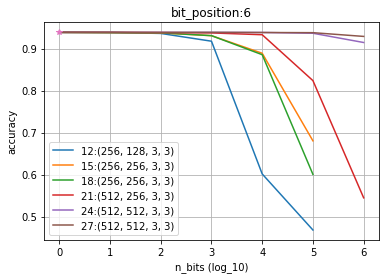

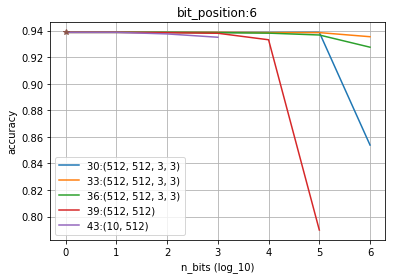

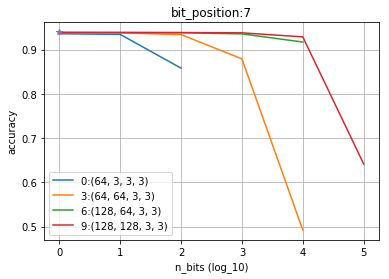

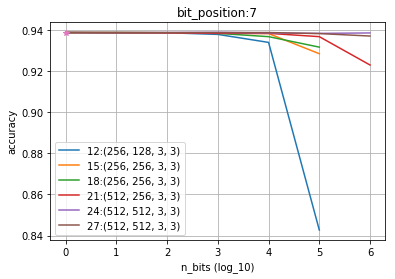

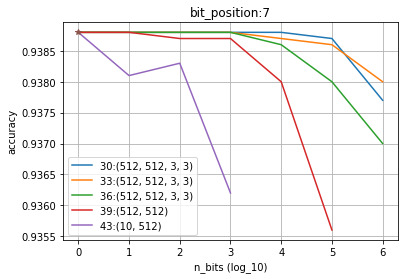

In [99]:
# x: fault count, y:accuracy; lengends: param_id 
#import math 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for bit_position in range(0, 8):
            
            for param_id in sorted(data[model_type][fault_type].keys()):
                if param_id not in weights_id:
                    continue 
                res = data[model_type][fault_type][param_id][bit_position]
                n_bits_list = sorted(res.keys())
                num_values = res[n_bits_list[0]][0, 0]

                #fault_rates = [n_bits*1.0/num_values for n_bits in n_bits_list]
#                 print(fault_rates)
                accuracies = [np.min(res[n_bits], axis=0)[2] for n_bits in n_bits_list]
                plt.plot([math.log10(x) for x in n_bits_list], accuracies, 
                         label='%d:%s' %(param_id, param_id_to_shape[param_id]))
                
                if param_id in [9, 27, 43]:
                    plt.legend()    
        #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
                    plt.grid()
                    plt.ylabel('accuracy')
                    plt.xlabel('n_bits (log_10)')
                    plt.title('bit_position:%d' %(bit_position))
                    plt.plot(fault_free_accuracy, marker='*')
                    plt.show()
    

In [47]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

def parse_stats(stats):
    # input format:
    # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
    # output format: 
    # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
    param_stats = {'changed_params':0, 
                               'flip_to_one': np.zeros(32), 
                               'flip_to_zero': np.zeros(32),
                              'value_before_flip': [],
                              'value_after_flip':[], 
                              'flipped_positions': []}
            
    for value_id, flip_list in stats.items():
        param_stats['changed_params'] += 1
        param_stats['value_before_flip'].append(round(flip_list[0][0], 6))
        param_stats['value_after_flip'].append(round(flip_list[-1][-1], 6))
        param_stats['flipped_positions'].append([x[1] for x in flip_list])

        for _, flip_pos, flip_bit, flip_value in flip_list:
#             print(flip_list)
            if flip_bit:
                param_stats['flip_to_one'][flip_pos] += 1
            else:
                param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f)
#         print(stats)
         
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    

fault_rate: 0.002713
accuracies: [0.9356 0.9362 0.9341 0.9343 0.9375 0.9339 0.9369 0.9337 0.9384 0.9369]
flip_to_one: 144, flip_to_zero: 156
[(-0.070212, -0.017553), (-0.045373, -0.011343), (0.019165, 0.076662), (0.000144, 3.6e-05), (-0.074137, -0.018534), (0.014632, 0.05853), (0.024123, 0.096491), (-0.083828, -0.020957), (-0.03999, -0.009997), (-0.022563, -0.090252)]


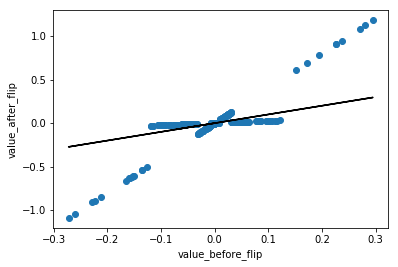

In [98]:

model_type = 'full'
fault_type = 'faults_layer'
param_id = 3
bit_position = 7
n_bits = 100
print('fault_rate: %f' %(n_bits*1.0/data[model_type][fault_type][param_id][bit_position][n_bits][0,0]))
print('accuracies:', data[model_type][fault_type][param_id][bit_position][n_bits][:, 2])

folder = 'param-%d/bit-%d/nbits-%d' %(param_id, bit_position, n_bits)
results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

avg_params_stats = load_and_average_stats(results_dir, range(3)) 
# print(avg_params_stats)
# plt.bar(range(32), avg_params_stats['flip_to_one'])
# plt.title('flip to one')
# plt.show()

# plt.bar(range(32), avg_params_stats['flip_to_zero'])
# plt.title('flip to zero')
# plt.show() 
print('flip_to_one: %d, flip_to_zero: %d' 
      %(avg_params_stats['flip_to_one'][bit_position], avg_params_stats['flip_to_zero'][bit_position]))

print(list(zip(avg_params_stats['value_before_flip'][:10], avg_params_stats['value_after_flip'][:10])))
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 'o')
plt.xlabel('value_before_flip')
plt.ylabel('value_after_flip')
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
plt.show()

In [62]:
import torch 
import models

def load_checkpoint(model, model_path):
    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model_path)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            raise ValueError("=> no checkpoint found at '{}'".format(model_path))
    else:
        raise ValueError('model_path cannot be empty!')
    return best_prec1 
arch = 'vgg'
depth = 16 
model_path = './logs/vgg16/cifar10/model_best.pth.tar'
checkpoint = torch.load(model_path)
model = models.__dict__[arch](dataset=dataset_name, depth=depth, cfg=checkpoint['cfg'])
best_prec1 = load_checkpoint(model, model_path)


=> loading checkpoint './logs/vgg16/cifar10/model_best.pth.tar'
=> loaded checkpoint './logs/vgg16/cifar10/model_best.pth.tar' (epoch 158) Prec1: 0.938800


(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00,
        5.00000e+00, 9.00000e+00, 7.00000e+00, 1.80000e+01, 4.30000e+01,
        4.30000e+01, 5.90000e+01, 8.50000e+01, 1.71000e+02, 3.51000e+02,
        6.47000e+02, 1.50200e+03, 3.65100e+03, 1.00940e+04, 3.60250e+04,
        1.32486e+05, 4.80170e+04, 1.54710e+04, 6.46400e+03, 3.02900e+03,
        1.62700e+03, 8.61000e+02, 4.84000e+02, 2.81000e+02, 2.19000e+02,
        1.19000e+02, 9.40000e+01, 6.60000e+01, 4.90000e+01, 3.20000e+01,
        2.50000e+01, 2.00000e+01, 1.60000e+01, 1.20000e+01, 3.00000e+00,
        9.00000e+00, 4.00000e+00, 3.00000e+00, 1.00

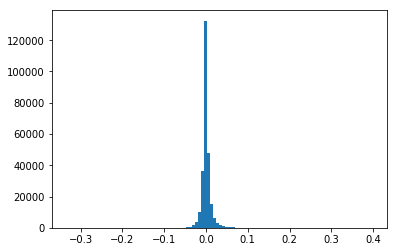

In [84]:
param_id = 39
plt.hist(list(model.parameters())[param_id].data.cpu().numpy().ravel(), bins=100)